# Chemical Process Anomaly Detection isolation forest Baseline 🕵️
### 화학 공정 데이터를 분석하고 🧐, 이상 탐지 Baseline Model 을 학습합니다 📖.


## Table of Contents
1. 필요 Library Import
2. Load Data
3. EDA
4. Data Process
5. Model Training
6. Model Inference


### 1. 필요 Library Import

- 노트북에서 사용하는 필요 Library 를 import 합니다

In [1]:
from typing import Union
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import SGDOneClassSVM
from sklearn.metrics import accuracy_score

- 모델 학습에 필요한 `random_seed` 를 설정하고, `DATA_PATH` 를 설정합니다.
- 해당 `DATA_PATH` 에는 `train.csv`, `test.csv` 파일이 있다고 가정합니다.

In [2]:
RANDOM_SEED = 42
DATA_PATH = Path("../../data")

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


### 2. Load Train Data


In [3]:
train_data = pd.read_csv(DATA_PATH / "train.csv")

### 고민해볼 사항 🤔
- 일반적인 ML Model 에서 상관관계가 거의 1인 변수들의 경우, 중복된 정보량을 담고 있으므로 학습에 제거하는 경우가 있습니다.
- 하지만 학습 데이터인 **정상 데이터 대해 상관 관계를 계산** 한 것이고, 비정상 데이터에선 동일 데이터의 상관관계가 달라질 수 있습니다.
- 실제 화학 공정에서 이상이 발생하는 경우는 특정 변수들과의 상관 관계가 깨지는 경우도 포함될 수 있습니다.
- 따라서, 상관 관계에 따라 변수를 선택할지 제거할지 결정할 땐 **모델의 성능**과 같이 고려하는 것이 바람직합니다.

### 4. Data Process

- `simulationRun` 과 `sample` 변수는 큰 정보량을 담고 있지 않기 때문에, 공정의 센서 값을 반영하는 변수들을 선택합니다.
- 따라서, `process_data` 함수에서는 `xmeas`, `xmv` 와 같은 숫자형 변수들을(numerical value) 초도 모델 학습에 사용합니다.
- 정규화와 feature engineering의 과정은 포함되지 않았으므로, `process_data` 함수 전, 후로 더 다양한 전처리 과정을 추가해보시길 권장합니다.

In [4]:
train_data

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,0.0,500.0,496,0.29325,3640.1,4473.0,9.1949,26.867,42.379,2700.2,...,53.429,29.249,60.773,21.532,40.451,34.064,48.953,48.291,40.812,18.756
249996,0.0,500.0,497,0.29134,3625.7,4506.2,9.2109,26.889,42.291,2700.6,...,53.830,28.975,61.517,21.750,42.762,42.645,51.055,48.589,40.933,19.360
249997,0.0,500.0,498,0.29438,3600.2,4478.3,9.1957,26.820,42.448,2700.3,...,54.163,28.676,61.656,21.487,42.109,39.770,46.770,48.648,41.465,19.344
249998,0.0,500.0,499,0.25269,3683.5,4486.4,9.2832,27.188,42.757,2697.4,...,53.453,24.889,61.564,21.392,39.334,42.274,43.623,48.797,39.835,18.512


In [5]:
# CV (Holdout)

from sklearn.model_selection import train_test_split

train, valid = train_test_split(train_data, test_size=0.2, train_size=0.8, shuffle=False, random_state=42)

In [6]:
train

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.0,1.0,1,0.25038,3674.0,4529.0,9.2320,26.889,42.402,2704.3,...,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510,41.258,18.447
1,0.0,1.0,2,0.25109,3659.4,4556.6,9.4264,26.721,42.576,2705.0,...,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427,41.359,17.194
2,0.0,1.0,3,0.25038,3660.3,4477.8,9.4426,26.875,42.070,2706.2,...,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468,41.199,20.530
3,0.0,1.0,4,0.24977,3661.3,4512.1,9.4776,26.758,42.063,2707.2,...,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658,41.643,18.089
4,0.0,1.0,5,0.29405,3679.0,4497.0,9.3381,26.889,42.650,2705.1,...,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346,41.507,18.461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.0,400.0,496,0.29191,3676.7,4456.9,9.4452,26.689,42.504,2706.4,...,53.732,28.402,60.841,21.957,37.973,40.311,42.816,47.818,41.116,16.955
199996,0.0,400.0,497,0.24778,3691.3,4498.1,9.3257,26.414,42.471,2707.3,...,53.202,24.555,59.236,21.905,41.039,36.290,46.187,47.915,40.748,17.308
199997,0.0,400.0,498,0.24895,3695.1,4433.4,9.3988,27.284,42.443,2707.0,...,53.977,24.440,58.984,22.534,41.305,40.254,47.149,47.861,41.448,17.213
199998,0.0,400.0,499,0.24474,3612.5,4524.9,9.2540,26.731,42.554,2706.4,...,53.662,24.171,61.859,22.148,39.913,44.066,44.604,48.226,40.277,17.532


In [7]:
valid

,faultNumber,simulationRun,sample,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
200000,0.0,401.0,1,0.25054,3686.5,4501.8,9.3955,26.916,42.373,2705.1,...,54.070,24.642,60.308,21.984,39.940,36.498,46.691,47.475,41.146,16.989
200001,0.0,401.0,2,0.25111,3701.8,4520.6,9.2658,26.784,42.283,2704.1,...,53.844,24.586,61.839,21.795,39.869,35.715,42.640,47.410,41.149,19.913
200002,0.0,401.0,3,0.25082,3650.1,4480.4,9.5978,26.529,42.069,2705.4,...,54.325,24.623,60.735,22.010,40.095,39.034,46.357,47.496,41.607,18.176
200003,0.0,401.0,4,0.25198,3678.9,4521.1,9.3202,26.364,42.489,2706.1,...,53.838,24.508,61.988,21.983,39.895,36.809,48.643,47.413,41.721,16.477
200004,0.0,401.0,5,0.25396,3709.8,4476.9,9.4912,26.584,42.663,2706.1,...,53.866,24.941,60.016,22.028,42.620,42.057,48.404,47.375,40.859,19.194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,0.0,500.0,496,0.29325,3640.1,4473.0,9.1949,26.867,42.379,2700.2,...,53.429,29.249,60.773,21.532,40.451,34.064,48.953,48.291,40.812,18.756
249996,0.0,500.0,497,0.29134,3625.7,4506.2,9.2109,26.889,42.291,2700.6,...,53.830,28.975,61.517,21.750,42.762,42.645,51.055,48.589,40.933,19.360
249997,0.0,500.0,498,0.29438,3600.2,4478.3,9.1957,26.820,42.448,2700.3,...,54.163,28.676,61.656,21.487,42.109,39.770,46.770,48.648,41.465,19.344
249998,0.0,500.0,499,0.25269,3683.5,4486.4,9.2832,27.188,42.757,2697.4,...,53.453,24.889,61.564,21.392,39.334,42.274,43.623,48.797,39.835,18.512


In [8]:
def process_data(df) -> pd.DataFrame:
    numeric_cols = [
        'xmeas_1', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14',
        'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_2',
        'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25',
        'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_3', 'xmeas_30',
        'xmeas_31', 'xmeas_32', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36',
        'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_4', 'xmeas_40', 'xmeas_41',
        'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 'xmv_1',
        'xmv_10', 'xmv_11', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6',
        'xmv_7', 'xmv_8', 'xmv_9'
    ]
    return df[numeric_cols]

In [9]:
train_X = process_data(train)
train_y = train["faultNumber"]
valid_X = process_data(valid)
valid_y = valid["faultNumber"]

In [10]:
display(train_X)
display(train_y)
display(valid_X)
display(valid_y)

,xmeas_1,xmeas_10,xmeas_11,xmeas_12,xmeas_13,xmeas_14,xmeas_15,xmeas_16,xmeas_17,xmeas_18,...,xmv_10,xmv_11,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9
0,0.25038,0.33818,80.044,51.435,2632.9,25.029,50.528,3101.1,22.819,65.732,...,41.258,18.447,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510
1,0.25109,0.33620,80.078,50.154,2633.8,24.419,48.772,3102.0,23.333,65.716,...,41.359,17.194,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427
2,0.25038,0.33563,80.220,50.302,2635.5,25.244,50.071,3103.5,21.924,65.732,...,41.199,20.530,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468
3,0.24977,0.33553,80.305,49.990,2635.6,23.268,50.435,3102.8,22.948,65.781,...,41.643,18.089,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658
4,0.29405,0.32632,80.064,51.310,2632.4,26.099,50.480,3103.5,22.808,65.788,...,41.507,18.461,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.29191,0.33213,79.867,50.751,2635.3,26.339,48.394,3104.2,23.454,65.704,...,41.116,16.955,53.732,28.402,60.841,21.957,37.973,40.311,42.816,47.818
199996,0.24778,0.34846,80.113,49.385,2636.7,27.328,49.850,3104.7,23.289,65.710,...,40.748,17.308,53.202,24.555,59.236,21.905,41.039,36.290,46.187,47.915
199997,0.24895,0.34628,80.241,50.732,2636.4,25.170,50.266,3105.0,23.323,65.779,...,41.448,17.213,53.977,24.440,58.984,22.534,41.305,40.254,47.149,47.861
199998,0.24474,0.33267,80.287,52.027,2635.1,23.853,49.166,3103.7,23.181,65.840,...,40.277,17.532,53.662,24.171,61.859,22.148,39.913,44.066,44.604,48.226


0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
199995    0.0
199996    0.0
199997    0.0
199998    0.0
199999    0.0
Name: faultNumber, Length: 200000, dtype: float64

,xmeas_1,xmeas_10,xmeas_11,xmeas_12,xmeas_13,xmeas_14,xmeas_15,xmeas_16,xmeas_17,xmeas_18,...,xmv_10,xmv_11,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9
200000,0.25054,0.33814,80.140,49.456,2633.0,25.584,50.068,3102.7,23.424,65.716,...,41.146,16.989,54.070,24.642,60.308,21.984,39.940,36.498,46.691,47.475
200001,0.25111,0.33872,80.037,49.190,2632.6,25.212,48.317,3102.6,22.192,65.731,...,41.149,19.913,53.844,24.586,61.839,21.795,39.869,35.715,42.640,47.410
200002,0.25082,0.33685,80.139,50.317,2634.5,23.778,49.923,3102.6,22.918,65.707,...,41.607,18.176,54.325,24.623,60.735,22.010,40.095,39.034,46.357,47.496
200003,0.25198,0.33849,80.143,49.561,2635.1,24.107,50.911,3102.6,23.627,65.726,...,41.721,16.477,53.838,24.508,61.988,21.983,39.895,36.809,48.643,47.413
200004,0.25396,0.35448,80.306,51.345,2635.1,24.578,50.808,3103.6,22.484,65.762,...,40.859,19.194,53.866,24.941,60.016,22.028,42.620,42.057,48.404,47.375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,0.29325,0.34050,80.146,48.628,2628.4,24.419,51.045,3097.9,22.738,65.759,...,40.812,18.756,53.429,29.249,60.773,21.532,40.451,34.064,48.953,48.291
249996,0.29134,0.35374,80.350,51.544,2628.5,25.637,51.954,3098.7,22.464,65.830,...,40.933,19.360,53.830,28.975,61.517,21.750,42.762,42.645,51.055,48.589
249997,0.29438,0.35910,80.445,50.567,2628.7,25.430,50.102,3100.4,22.465,65.928,...,41.465,19.344,54.163,28.676,61.656,21.487,42.109,39.770,46.770,48.648
249998,0.25269,0.32469,80.332,51.418,2625.7,24.280,48.742,3098.2,22.815,65.984,...,39.835,18.512,53.453,24.889,61.564,21.392,39.334,42.274,43.623,48.797


200000    0.0
200001    0.0
200002    0.0
200003    0.0
200004    0.0
         ... 
249995    0.0
249996    0.0
249997    0.0
249998    0.0
249999    0.0
Name: faultNumber, Length: 50000, dtype: float64

### 5. Model Training

- 위에서 전처리한 `train_X` 데이터를 이용하여 모델을 학습합니다.
- 초기 baseline model 은 `scikit-learn` 의 `IsolationForest` 와 `SGDOneClassSVM` 모델을 사용했습니다.
- 각 Model의 HyperParameter Tuning을 위한 Validation Set 은 따로 구성하지 않았습니다. 다양한 방식으로 구성하며 Model을 고도화해보시길 권장드립니다.
- Model 별로 Tuning 가능한 Parameter 정보는 다음 document 를 참고하시기 바랍니다.
  - [Isolation Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest)
  - [SGDOneClassSVM](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDOneClassSVM.html#sklearn.linear_model.SGDOneClassSVM)

In [11]:
import optuna

def objective(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_samples": "auto", # Default
        "contamination": trial.suggest_float("contamination", 0.01, 0.5),
        "max_features": trial.suggest_int("max_features", 30, 52),
        # "bootstrap" : trial.suggest_categorical("bootstrap", [True, False]), # True일 떄가 보편적으로 성적이 높게 나옴
        "n_jobs" : -1, # Default
        "random_state" : RANDOM_SEED,
        "verbose" : 0, # Default
        "warm_start": trial.suggest_categorical("warm_start", [False, True])
    }
    
    if_model = IsolationForest(**param)
    if_model.fit(train_X)
    
    pred_y = if_model.predict(valid_X)
    
    if -1 in pred_y:
        # inliers: 1 -> 0 , outliers: -1 -> 1 : 보통은 이상치를 Positive로 정상치를 Negative로 둔다 하지만 여기서는 정상치를 Positive로 이상치를 Negative로 두었다.
        pred_y = (pred_y == -1).astype(int)
    
    valid["pred"] = pred_y    
    print(valid.groupby("simulationRun")["pred"].sum().sort_values(ascending=False).head(5)) # 한 simulationRun에서 이상치가 발생한 개수 Top 5를 뽑아서 보여줌
    
    return accuracy_score(valid_y, pred_y)
    

In [13]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials=50)

[I 2024-05-10 16:25:48,488] A new study created in memory with name: no-name-d51115f2-3e62-4317-8b04-6a630fe50f39
[I 2024-05-10 16:25:55,374] Trial 0 finished with value: 0.76374 and parameters: {'n_estimators': 846, 'contamination': 0.25290737693887927, 'max_features': 52, 'warm_start': True}. Best is trial 0 with value: 0.76374.


simulationRun
451.0    292
459.0    265
466.0    223
440.0    217
406.0    208
Name: pred, dtype: int64


[I 2024-05-10 16:26:00,795] Trial 1 finished with value: 0.58588 and parameters: {'n_estimators': 426, 'contamination': 0.4312714700502159, 'max_features': 48, 'warm_start': True}. Best is trial 0 with value: 0.76374.


simulationRun
451.0    363
459.0    331
466.0    317
406.0    292
437.0    291
Name: pred, dtype: int64


[I 2024-05-10 16:26:08,687] Trial 2 finished with value: 0.59202 and parameters: {'n_estimators': 621, 'contamination': 0.4254543721968982, 'max_features': 41, 'warm_start': False}. Best is trial 0 with value: 0.76374.


simulationRun
451.0    363
459.0    331
466.0    312
437.0    294
435.0    289
Name: pred, dtype: int64


[I 2024-05-10 16:26:17,723] Trial 3 finished with value: 0.86096 and parameters: {'n_estimators': 757, 'contamination': 0.1515330262739545, 'max_features': 42, 'warm_start': True}. Best is trial 3 with value: 0.86096.


simulationRun
451.0    224
459.0    209
406.0    159
466.0    152
440.0    146
Name: pred, dtype: int64


[I 2024-05-10 16:26:23,738] Trial 4 finished with value: 0.6722 and parameters: {'n_estimators': 478, 'contamination': 0.34770227848748214, 'max_features': 47, 'warm_start': True}. Best is trial 3 with value: 0.86096.


simulationRun
451.0    337
459.0    301
466.0    275
440.0    252
435.0    250
Name: pred, dtype: int64


[I 2024-05-10 16:26:28,066] Trial 5 finished with value: 0.7634 and parameters: {'n_estimators': 345, 'contamination': 0.2538584906313106, 'max_features': 47, 'warm_start': False}. Best is trial 3 with value: 0.86096.


simulationRun
451.0    281
459.0    257
466.0    218
440.0    208
406.0    208
Name: pred, dtype: int64


[I 2024-05-10 16:26:38,780] Trial 6 finished with value: 0.59614 and parameters: {'n_estimators': 876, 'contamination': 0.4211399265220492, 'max_features': 46, 'warm_start': True}. Best is trial 3 with value: 0.86096.


simulationRun
451.0    360
459.0    336
466.0    313
437.0    285
440.0    284
Name: pred, dtype: int64


[I 2024-05-10 16:26:49,104] Trial 7 finished with value: 0.89302 and parameters: {'n_estimators': 836, 'contamination': 0.11592296538049095, 'max_features': 47, 'warm_start': True}. Best is trial 7 with value: 0.89302.


simulationRun
459.0    193
451.0    192
406.0    136
426.0    133
436.0    122
Name: pred, dtype: int64


[I 2024-05-10 16:26:52,091] Trial 8 finished with value: 0.80364 and parameters: {'n_estimators': 235, 'contamination': 0.20977952188931093, 'max_features': 46, 'warm_start': True}. Best is trial 7 with value: 0.89302.


simulationRun
451.0    259
459.0    252
406.0    191
466.0    187
440.0    175
Name: pred, dtype: int64


[I 2024-05-10 16:27:03,505] Trial 9 finished with value: 0.76894 and parameters: {'n_estimators': 948, 'contamination': 0.24696854300773943, 'max_features': 38, 'warm_start': True}. Best is trial 7 with value: 0.89302.


simulationRun
451.0    275
459.0    264
466.0    222
406.0    202
440.0    199
Name: pred, dtype: int64


[I 2024-05-10 16:27:10,305] Trial 10 finished with value: 0.97558 and parameters: {'n_estimators': 639, 'contamination': 0.025492043403101072, 'max_features': 30, 'warm_start': False}. Best is trial 10 with value: 0.97558.


simulationRun
459.0    83
451.0    77
426.0    64
407.0    50
406.0    48
Name: pred, dtype: int64


[I 2024-05-10 16:27:17,279] Trial 11 finished with value: 0.98576 and parameters: {'n_estimators': 658, 'contamination': 0.014783165167191206, 'max_features': 31, 'warm_start': False}. Best is trial 11 with value: 0.98576.


simulationRun
459.0    53
451.0    52
426.0    49
407.0    31
406.0    28
Name: pred, dtype: int64


[I 2024-05-10 16:27:24,142] Trial 12 finished with value: 0.97978 and parameters: {'n_estimators': 636, 'contamination': 0.021045100559843877, 'max_features': 30, 'warm_start': False}. Best is trial 11 with value: 0.98576.


simulationRun
459.0    73
451.0    70
426.0    57
407.0    47
406.0    43
Name: pred, dtype: int64


[I 2024-05-10 16:27:31,092] Trial 13 finished with value: 0.98362 and parameters: {'n_estimators': 649, 'contamination': 0.017099998161604967, 'max_features': 31, 'warm_start': False}. Best is trial 11 with value: 0.98576.


simulationRun
459.0    60
451.0    59
426.0    49
407.0    37
406.0    31
Name: pred, dtype: int64


[I 2024-05-10 16:27:32,442] Trial 14 finished with value: 0.91318 and parameters: {'n_estimators': 116, 'contamination': 0.09199408011887109, 'max_features': 34, 'warm_start': False}. Best is trial 11 with value: 0.98576.


simulationRun
451.0    172
459.0    169
426.0    117
406.0    109
481.0    101
Name: pred, dtype: int64


[I 2024-05-10 16:27:38,680] Trial 15 finished with value: 0.93588 and parameters: {'n_estimators': 554, 'contamination': 0.06913220749235682, 'max_features': 34, 'warm_start': False}. Best is trial 11 with value: 0.98576.


simulationRun
451.0    154
459.0    147
426.0    103
406.0    100
440.0     80
Name: pred, dtype: int64


[I 2024-05-10 16:27:46,743] Trial 16 finished with value: 0.84522 and parameters: {'n_estimators': 714, 'contamination': 0.16954214907270096, 'max_features': 34, 'warm_start': False}. Best is trial 11 with value: 0.98576.


simulationRun
451.0    243
459.0    227
466.0    166
406.0    164
470.0    157
Name: pred, dtype: int64


[I 2024-05-10 16:27:55,545] Trial 17 finished with value: 0.69606 and parameters: {'n_estimators': 742, 'contamination': 0.32295049375875623, 'max_features': 37, 'warm_start': False}. Best is trial 11 with value: 0.98576.


simulationRun
451.0    314
459.0    290
466.0    262
406.0    246
437.0    245
Name: pred, dtype: int64


[I 2024-05-10 16:28:06,898] Trial 18 finished with value: 0.94292 and parameters: {'n_estimators': 1000, 'contamination': 0.06204794942912703, 'max_features': 32, 'warm_start': False}. Best is trial 11 with value: 0.98576.


simulationRun
451.0    141
459.0    140
426.0    101
406.0     96
407.0     78
Name: pred, dtype: int64


[I 2024-05-10 16:28:13,129] Trial 19 finished with value: 0.98736 and parameters: {'n_estimators': 501, 'contamination': 0.012953632443447176, 'max_features': 37, 'warm_start': False}. Best is trial 19 with value: 0.98736.


simulationRun
459.0    52
451.0    46
426.0    40
431.0    30
407.0    29
Name: pred, dtype: int64


[I 2024-05-10 16:28:17,507] Trial 20 finished with value: 0.51966 and parameters: {'n_estimators': 366, 'contamination': 0.4949637726842301, 'max_features': 39, 'warm_start': False}. Best is trial 19 with value: 0.98736.


simulationRun
451.0    383
459.0    353
466.0    338
493.0    323
437.0    321
Name: pred, dtype: int64


[I 2024-05-10 16:28:23,630] Trial 21 finished with value: 0.98636 and parameters: {'n_estimators': 538, 'contamination': 0.01447711154970165, 'max_features': 36, 'warm_start': False}. Best is trial 19 with value: 0.98736.


simulationRun
451.0    59
459.0    58
426.0    50
406.0    32
431.0    29
Name: pred, dtype: int64


[I 2024-05-10 16:28:29,496] Trial 22 finished with value: 0.8895 and parameters: {'n_estimators': 513, 'contamination': 0.12149586149735064, 'max_features': 36, 'warm_start': False}. Best is trial 19 with value: 0.98736.


simulationRun
451.0    207
459.0    201
406.0    143
426.0    129
466.0    124
Name: pred, dtype: int64


[I 2024-05-10 16:28:36,178] Trial 23 finished with value: 0.9463 and parameters: {'n_estimators': 558, 'contamination': 0.058616463635856764, 'max_features': 43, 'warm_start': False}. Best is trial 19 with value: 0.98736.


simulationRun
451.0    139
459.0    134
426.0    102
406.0     91
407.0     76
Name: pred, dtype: int64


[I 2024-05-10 16:28:40,649] Trial 24 finished with value: 0.8449 and parameters: {'n_estimators': 392, 'contamination': 0.16926048071903085, 'max_features': 36, 'warm_start': False}. Best is trial 19 with value: 0.98736.


simulationRun
451.0    239
459.0    230
406.0    165
466.0    157
470.0    153
Name: pred, dtype: int64


[I 2024-05-10 16:28:45,861] Trial 25 finished with value: 0.98852 and parameters: {'n_estimators': 442, 'contamination': 0.012257787334619828, 'max_features': 39, 'warm_start': False}. Best is trial 25 with value: 0.98852.


simulationRun
451.0    45
426.0    43
459.0    40
431.0    26
406.0    24
Name: pred, dtype: int64


[I 2024-05-10 16:28:49,230] Trial 26 finished with value: 0.9028 and parameters: {'n_estimators': 282, 'contamination': 0.10599623520269082, 'max_features': 39, 'warm_start': False}. Best is trial 25 with value: 0.98852.


simulationRun
451.0    182
459.0    172
406.0    135
426.0    122
466.0    117
Name: pred, dtype: int64


[I 2024-05-10 16:28:54,834] Trial 27 finished with value: 0.95128 and parameters: {'n_estimators': 455, 'contamination': 0.05307508474386382, 'max_features': 40, 'warm_start': False}. Best is trial 25 with value: 0.98852.


simulationRun
459.0    123
451.0    119
426.0     92
406.0     77
407.0     77
Name: pred, dtype: int64


[I 2024-05-10 16:28:58,686] Trial 28 finished with value: 0.92594 and parameters: {'n_estimators': 318, 'contamination': 0.08011875021667152, 'max_features': 44, 'warm_start': False}. Best is trial 25 with value: 0.98852.


simulationRun
451.0    156
459.0    150
426.0    112
406.0    111
481.0     85
Name: pred, dtype: int64


[I 2024-05-10 16:29:00,304] Trial 29 finished with value: 0.87766 and parameters: {'n_estimators': 189, 'contamination': 0.1335754246114404, 'max_features': 52, 'warm_start': False}. Best is trial 25 with value: 0.98852.


simulationRun
451.0    209
459.0    199
406.0    136
426.0    135
436.0    129
Name: pred, dtype: int64


[I 2024-05-10 16:29:06,605] Trial 30 finished with value: 0.81546 and parameters: {'n_estimators': 543, 'contamination': 0.20176227254712026, 'max_features': 36, 'warm_start': False}. Best is trial 25 with value: 0.98852.


simulationRun
451.0    259
459.0    251
466.0    185
406.0    184
470.0    178
Name: pred, dtype: int64


[I 2024-05-10 16:29:13,140] Trial 31 finished with value: 0.98888 and parameters: {'n_estimators': 591, 'contamination': 0.012359997027767812, 'max_features': 33, 'warm_start': False}. Best is trial 31 with value: 0.98888.


simulationRun
459.0    47
451.0    43
426.0    40
431.0    25
406.0    24
Name: pred, dtype: int64


[I 2024-05-10 16:29:18,101] Trial 32 finished with value: 0.9607 and parameters: {'n_estimators': 439, 'contamination': 0.04228269075236212, 'max_features': 33, 'warm_start': False}. Best is trial 31 with value: 0.98888.


simulationRun
459.0    112
451.0    111
426.0     82
406.0     76
407.0     65
Name: pred, dtype: int64


[I 2024-05-10 16:29:23,601] Trial 33 finished with value: 0.9219 and parameters: {'n_estimators': 494, 'contamination': 0.0852925732465168, 'max_features': 35, 'warm_start': False}. Best is trial 31 with value: 0.98888.


simulationRun
451.0    173
459.0    163
406.0    116
426.0    112
466.0     97
Name: pred, dtype: int64


[I 2024-05-10 16:29:30,184] Trial 34 finished with value: 0.96114 and parameters: {'n_estimators': 576, 'contamination': 0.042312981626300185, 'max_features': 38, 'warm_start': False}. Best is trial 31 with value: 0.98888.


simulationRun
451.0    119
459.0    107
426.0     83
406.0     71
407.0     67
Name: pred, dtype: int64


[I 2024-05-10 16:29:35,039] Trial 35 finished with value: 0.98958 and parameters: {'n_estimators': 408, 'contamination': 0.010109016738731894, 'max_features': 41, 'warm_start': False}. Best is trial 35 with value: 0.98958.


simulationRun
459.0    48
451.0    38
426.0    35
431.0    30
407.0    22
Name: pred, dtype: int64


[I 2024-05-10 16:29:39,955] Trial 36 finished with value: 0.70072 and parameters: {'n_estimators': 419, 'contamination': 0.3176357201224279, 'max_features': 41, 'warm_start': False}. Best is trial 35 with value: 0.98958.


simulationRun
451.0    319
459.0    286
466.0    262
440.0    244
406.0    236
Name: pred, dtype: int64


[I 2024-05-10 16:29:43,535] Trial 37 finished with value: 0.95486 and parameters: {'n_estimators': 302, 'contamination': 0.049779486171970866, 'max_features': 42, 'warm_start': True}. Best is trial 35 with value: 0.98958.


simulationRun
451.0    119
459.0    113
426.0     91
406.0     82
407.0     70
Name: pred, dtype: int64


[I 2024-05-10 16:29:50,682] Trial 38 finished with value: 0.86338 and parameters: {'n_estimators': 600, 'contamination': 0.15028033981721456, 'max_features': 40, 'warm_start': False}. Best is trial 35 with value: 0.98958.


simulationRun
451.0    222
459.0    212
406.0    158
466.0    146
426.0    146
Name: pred, dtype: int64


[I 2024-05-10 16:29:56,496] Trial 39 finished with value: 0.63432 and parameters: {'n_estimators': 471, 'contamination': 0.38445020283442555, 'max_features': 43, 'warm_start': True}. Best is trial 35 with value: 0.98958.


simulationRun
451.0    348
459.0    325
466.0    300
440.0    274
406.0    272
Name: pred, dtype: int64


[I 2024-05-10 16:30:04,898] Trial 40 finished with value: 0.91278 and parameters: {'n_estimators': 698, 'contamination': 0.09472634310865327, 'max_features': 38, 'warm_start': False}. Best is trial 35 with value: 0.98958.


simulationRun
451.0    177
459.0    173
406.0    122
426.0    115
466.0    102
Name: pred, dtype: int64


[I 2024-05-10 16:30:11,247] Trial 41 finished with value: 0.99018 and parameters: {'n_estimators': 524, 'contamination': 0.010180592819539105, 'max_features': 37, 'warm_start': False}. Best is trial 41 with value: 0.99018.


simulationRun
459.0    44
451.0    36
426.0    36
431.0    25
406.0    20
Name: pred, dtype: int64


[I 2024-05-10 16:30:16,556] Trial 42 finished with value: 0.98936 and parameters: {'n_estimators': 408, 'contamination': 0.010377717103929826, 'max_features': 41, 'warm_start': False}. Best is trial 41 with value: 0.99018.


simulationRun
459.0    48
451.0    39
426.0    35
431.0    30
407.0    23
Name: pred, dtype: int64


[I 2024-05-10 16:30:21,443] Trial 43 finished with value: 0.96288 and parameters: {'n_estimators': 398, 'contamination': 0.039948817804016684, 'max_features': 41, 'warm_start': False}. Best is trial 41 with value: 0.99018.


simulationRun
459.0    106
451.0     95
426.0     81
406.0     63
407.0     62
Name: pred, dtype: int64


[I 2024-05-10 16:30:25,635] Trial 44 finished with value: 0.96416 and parameters: {'n_estimators': 349, 'contamination': 0.038435384824705605, 'max_features': 44, 'warm_start': True}. Best is trial 41 with value: 0.99018.


simulationRun
459.0    105
451.0    103
426.0     79
406.0     66
407.0     56
Name: pred, dtype: int64


[I 2024-05-10 16:30:28,568] Trial 45 finished with value: 0.93024 and parameters: {'n_estimators': 239, 'contamination': 0.07523039508772461, 'max_features': 40, 'warm_start': False}. Best is trial 41 with value: 0.99018.


simulationRun
451.0    147
459.0    139
426.0    103
406.0    101
481.0     86
Name: pred, dtype: int64


[I 2024-05-10 16:30:33,864] Trial 46 finished with value: 0.97386 and parameters: {'n_estimators': 447, 'contamination': 0.027888120670208134, 'max_features': 42, 'warm_start': False}. Best is trial 41 with value: 0.99018.


simulationRun
459.0    84
451.0    82
426.0    67
407.0    53
406.0    47
Name: pred, dtype: int64


[I 2024-05-10 16:30:40,974] Trial 47 finished with value: 0.98844 and parameters: {'n_estimators': 598, 'contamination': 0.012454802204837571, 'max_features': 39, 'warm_start': False}. Best is trial 41 with value: 0.99018.


simulationRun
451.0    44
459.0    44
426.0    43
431.0    26
407.0    23
Name: pred, dtype: int64


[I 2024-05-10 16:30:46,103] Trial 48 finished with value: 0.93752 and parameters: {'n_estimators': 410, 'contamination': 0.06755335275089856, 'max_features': 44, 'warm_start': True}. Best is trial 41 with value: 0.99018.


simulationRun
451.0    143
459.0    138
426.0    104
406.0    102
407.0     80
Name: pred, dtype: int64


[I 2024-05-10 16:30:55,897] Trial 49 finished with value: 0.89998 and parameters: {'n_estimators': 806, 'contamination': 0.10953665500806835, 'max_features': 45, 'warm_start': False}. Best is trial 41 with value: 0.99018.


simulationRun
451.0    193
459.0    179
406.0    131
426.0    124
466.0    120
Name: pred, dtype: int64


In [14]:
study.best_params

{'n_estimators': 524,
 'contamination': 0.010180592819539105,
 'max_features': 37,
 'warm_start': False}

In [15]:
study.trials_dataframe().sort_values(by="value", ascending=False).head(20)

,number,value,datetime_start,datetime_complete,duration,params_contamination,params_max_features,params_n_estimators,params_warm_start,state
41,41,0.99018,2024-05-10 16:30:04.898463,2024-05-10 16:30:11.246931,0 days 00:00:06.348468,0.010181,37,524,False,COMPLETE
35,35,0.98958,2024-05-10 16:29:30.185139,2024-05-10 16:29:35.039404,0 days 00:00:04.854265,0.010109,41,408,False,COMPLETE
42,42,0.98936,2024-05-10 16:30:11.247414,2024-05-10 16:30:16.556720,0 days 00:00:05.309306,0.010378,41,408,False,COMPLETE
31,31,0.98888,2024-05-10 16:29:06.606142,2024-05-10 16:29:13.140646,0 days 00:00:06.534504,0.012360,33,591,False,COMPLETE
25,25,0.98852,2024-05-10 16:28:40.650056,2024-05-10 16:28:45.861645,0 days 00:00:05.211589,0.012258,39,442,False,COMPLETE
47,47,0.98844,2024-05-10 16:30:33.865219,2024-05-10 16:30:40.974735,0 days 00:00:07.109516,0.012455,39,598,False,COMPLETE
19,19,0.98736,2024-05-10 16:28:06.899049,2024-05-10 16:28:13.129611,0 days 00:00:06.230562,0.012954,37,501,False,COMPLETE
21,21,0.98636,2024-05-10 16:28:17.507614,2024-05-10 16:28:23.630072,0 days 00:00:06.122458,0.014477,36,538,False,COMPLETE
11,11,0.98576,2024-05-10 16:27:10.306331,2024-05-10 16:27:17.278974,0 days 00:00:06.972643,0.014783,31,658,False,COMPLETE
13,13,0.98362,2024-05-10 16:27:24.143277,2024-05-10 16:27:31.092198,0 days 00:00:06.948921,0.017100,31,649,False,COMPLETE


### 6. Model Inference
- 학습된 IsolationForest, SGDOneClassSVM 모델의 결과를 추론합니다.

### 주의할 점🚨
- 리더보드에서 채점되는 평가 코드는 Label 인 `faultNumber` 에 대해 정상을 `0`, 비정상을 `1` 로 채점합니다.
- 하지만 `IsolationForest` 같은 모델은 기본적으로 정상을 `1`, 비정상을 `-1` 출력합니다. 따라서 해당 모델의 Inference 결과 저장 시 `faultNumber` 인 column에 정상을 `0`, 비정상을 `1` 로 변환해야함을 유의해주시기 바랍니다.
- 아래 `inference` 함수에선 해당 변환 코드를 예시로 이미 추가했습니다.

In [16]:
train = process_data(train_data)
train

,xmeas_1,xmeas_10,xmeas_11,xmeas_12,xmeas_13,xmeas_14,xmeas_15,xmeas_16,xmeas_17,xmeas_18,...,xmv_10,xmv_11,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9
0,0.25038,0.33818,80.044,51.435,2632.9,25.029,50.528,3101.1,22.819,65.732,...,41.258,18.447,53.744,24.657,62.544,22.137,39.935,42.323,47.757,47.510
1,0.25109,0.33620,80.078,50.154,2633.8,24.419,48.772,3102.0,23.333,65.716,...,41.359,17.194,53.414,24.588,59.259,22.084,40.176,38.554,43.692,47.427
2,0.25038,0.33563,80.220,50.302,2635.5,25.244,50.071,3103.5,21.924,65.732,...,41.199,20.530,54.357,24.666,61.275,22.380,40.244,38.990,46.699,47.468
3,0.24977,0.33553,80.305,49.990,2635.6,23.268,50.435,3102.8,22.948,65.781,...,41.643,18.089,53.946,24.725,59.856,22.277,40.257,38.072,47.541,47.658
4,0.29405,0.32632,80.064,51.310,2632.4,26.099,50.480,3103.5,22.808,65.788,...,41.507,18.461,53.658,28.797,60.717,21.947,39.144,41.955,47.645,47.346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,0.29325,0.34050,80.146,48.628,2628.4,24.419,51.045,3097.9,22.738,65.759,...,40.812,18.756,53.429,29.249,60.773,21.532,40.451,34.064,48.953,48.291
249996,0.29134,0.35374,80.350,51.544,2628.5,25.637,51.954,3098.7,22.464,65.830,...,40.933,19.360,53.830,28.975,61.517,21.750,42.762,42.645,51.055,48.589
249997,0.29438,0.35910,80.445,50.567,2628.7,25.430,50.102,3100.4,22.465,65.928,...,41.465,19.344,54.163,28.676,61.656,21.487,42.109,39.770,46.770,48.648
249998,0.25269,0.32469,80.332,51.418,2625.7,24.280,48.742,3098.2,22.815,65.984,...,39.835,18.512,53.453,24.889,61.564,21.392,39.334,42.274,43.623,48.797


- 테스트 데이터를 Load 하여 확인합니다.
- 테스트 데이터는 총 710400 개의 row 와 Label column인 `faultNumber` 가 제외된 54개의 column을 갖고 있습니다.

In [17]:
test_data = pd.read_csv(DATA_PATH / "test.csv")
print(test_data.shape)

(710400, 54)


In [18]:
test_data.describe()

,sample,simulationRun,xmeas_1,xmeas_10,xmeas_11,xmeas_12,xmeas_13,xmeas_14,xmeas_15,xmeas_16,...,xmv_10,xmv_11,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9
count,710400.000000,710400.000000,710400.000000,710400.000000,710400.000000,710400.000000,710400.000000,710400.000000,710400.000000,710400.000000,...,710400.000000,710400.000000,710400.000000,710400.000000,710400.000000,710400.000000,710400.000000,710400.000000,710400.000000,710400.000000
mean,480.500000,369.500000,0.249465,0.341095,79.953159,49.986619,2641.728123,25.122148,49.978389,3110.263553,...,41.259162,18.557391,54.433897,25.987605,62.379721,23.152410,39.815532,38.060625,46.483987,48.282547
std,277.128174,213.619555,0.083627,0.054919,1.157381,1.004389,53.145656,1.071866,1.015070,51.116985,...,7.381448,4.632228,5.269215,11.779155,5.901141,9.787915,8.796930,2.955771,2.349162,11.511533
min,1.000000,0.000000,-0.003384,0.031363,69.702000,45.411000,2370.600000,19.903000,45.226000,2898.600000,...,-0.235790,-0.002547,21.135000,-0.142390,30.795000,-0.061391,0.000000,24.594000,35.486000,-0.654130
25%,240.750000,184.750000,0.225920,0.327170,79.912000,49.289000,2627.600000,24.424000,49.285000,3097.400000,...,40.702000,17.144000,53.625000,22.393000,60.446000,21.772000,38.838000,36.006000,44.879000,45.850000
50%,480.500000,369.500000,0.250260,0.336840,80.103000,49.995000,2633.700000,25.138000,49.962000,3102.300000,...,41.117000,18.201000,53.982000,24.735500,61.383000,22.193000,40.027000,38.085000,46.445000,47.863000
75%,720.250000,554.250000,0.273970,0.346450,80.288000,50.663000,2640.000000,25.840000,50.671000,3107.500000,...,41.538000,19.295000,54.346000,27.120000,62.362000,22.610000,41.201000,40.050000,48.087000,50.153000
max,960.000000,739.000000,1.016700,0.802510,86.631000,55.481000,2944.700000,31.182000,54.792000,3449.200000,...,100.230000,100.010000,100.000000,100.110000,100.020000,100.070000,95.638000,54.230000,57.625000,100.490000


- 하나의 `simulationRun` 에 대해 학습 데이터가 `500` 개 `sample` 인 반면, 테스트 데이터는 `960` 개의 `sample` 로 이루어져 있습니다.
- 또한, `simulationRun` 번호가 점진적으로 증가하지 않고, 정상/비정상인 `simulationRun` 이 무작위로 섞여있습니다.

In [19]:
from plotly.subplots import make_subplots
import plotly.express as px


subfig = make_subplots(specs=[[{"secondary_y": True}]])

fig1 = px.line(test_data[["simulationRun"]].iloc[:5000])
fig2 = px.line(test_data[["sample"]].iloc[:5000])
fig2.update_traces(yaxis="y2")

subfig.layout.yaxis.title="index"
subfig.layout.yaxis.title="simulationRun"
subfig.layout.yaxis2.title="sample"
subfig.layout.title = "Test data simulationRun and sample plot" 
subfig.add_traces(fig1.data + fig2.data)
subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))
subfig.show()

- 테스트 데이터에 대해 결과를 추론하여 결과를 확인합니다.
  - `faultNumber` 인 column에 모델 출력 값 정상이 `0`, 비정상이 `1` 이 pandas DataFrame 형태로 저장됐는지 확인합니다.

In [20]:
test_X = process_data(test_data)
test_X

,xmeas_1,xmeas_10,xmeas_11,xmeas_12,xmeas_13,xmeas_14,xmeas_15,xmeas_16,xmeas_17,xmeas_18,...,xmv_10,xmv_11,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9
0,0.24927,0.33775,80.122,50.119,2632.7,25.883,50.561,3101.9,23.826,65.725,...,40.319000,16.011,53.877,24.767,62.495,22.050,39.9870,38.451,47.832,47.427
1,0.25248,0.33964,80.075,49.453,2632.4,25.949,51.504,3101.8,22.006,65.746,...,41.286000,20.370,53.926,24.452,58.961,21.920,39.7560,36.490,50.014,47.059
2,0.25116,0.33801,80.147,48.533,2633.3,25.131,51.688,3102.2,23.820,65.730,...,41.210000,16.036,54.323,24.588,60.385,22.270,39.9540,33.784,50.440,47.592
3,0.24815,0.33556,80.163,48.250,2632.3,23.923,49.509,3102.8,24.000,65.743,...,41.183000,15.611,54.171,24.885,63.593,22.068,40.2530,32.951,45.397,47.591
4,0.23961,0.32149,80.138,48.410,2632.6,23.388,49.588,3102.2,23.582,65.780,...,41.701000,16.618,53.690,23.879,61.476,21.861,38.2170,33.422,45.579,47.524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710395,0.00000,0.20767,72.732,50.324,2920.8,25.377,49.508,3443.4,22.978,67.304,...,-0.025274,18.598,41.967,100.000,100.000,100.020,1.7372,39.055,45.394,100.410
710396,0.00000,0.20767,72.732,50.324,2920.8,25.377,49.508,3443.4,22.978,67.304,...,-0.025311,18.594,43.628,100.000,100.000,100.020,0.0000,39.055,45.394,100.410
710397,0.00000,0.20767,72.732,50.324,2920.8,25.377,49.508,3443.4,22.978,67.304,...,-0.025349,18.589,43.628,100.000,100.000,100.020,0.0000,39.055,45.394,100.410
710398,0.00000,0.20767,72.732,50.324,2920.8,25.377,49.508,3443.4,22.978,67.304,...,-0.025386,18.584,41.859,100.000,100.000,100.020,1.7723,39.055,45.394,100.410


In [21]:
best_params = {
        'n_estimators': 524,
        "max_samples": "auto", # Default
        'contamination': 0.010180592819539105,
        'max_features': 37,
        # "bootstrap" : trial.suggest_categorical("bootstrap", [True, False]), # True일 떄가 보편적으로 성적이 높게 나옴
        "n_jobs" : -1, # Default
        "random_state" : RANDOM_SEED,
        "verbose" : 0, # Default
        'warm_start': False
    }
if_best_model = IsolationForest(
    **best_params
)

if_best_model.fit(train)

IsolationForest(contamination=0.010180592819539105, max_features=37,
                n_estimators=524, n_jobs=-1, random_state=42)

In [22]:
def inference(test_X: pd.DataFrame, model):
    label_col = ["faultNumber"]
    pred_y = model.predict(test_X)
    if -1 in pred_y:
        # inliers: 1 -> 0 , outliers: -1 -> 1
        pred_y = (pred_y == -1).astype(int)
    return pd.DataFrame(pred_y, columns=label_col, index=test_X.index)

In [23]:
test_X = process_data(test_data)
pred_df = inference(test_X=test_X, model=if_best_model)
print(pred_df)

        faultNumber
0                 0
1                 0
2                 0
3                 0
4                 0
...             ...
710395            1
710396            1
710397            1
710398            1
710399            1

[710400 rows x 1 columns]


- 모델 추론 결과의 정상 / 비정상 비율을 확인합니다.

In [24]:
pred_df.value_counts()

faultNumber
0              611350
1               99050
Name: count, dtype: int64

In [25]:
min_anomal_num = 150
test_data["pred"] = pred_df

In [26]:
new = test_data.copy()
a = test_data.groupby("simulationRun")[["pred"]].sum() >= 150
index = a[a["pred"]==True].index

for i in index:
    new.loc[(new["simulationRun"]==i) & (new["pred"]==0)]["pred"] = 1

/var/folders/kv/46dvhwp932v4b692v761hjdc0000gn/T/ipykernel_85447/1830654944.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
predict = if_best_model.score_samples(test_X)
predict

array([-0.38630281, -0.38945529, -0.41964162, ..., -0.64208588,
       -0.63231387, -0.63231387])

<Axes: >

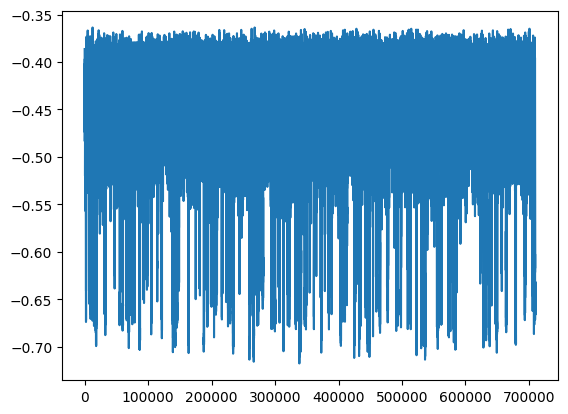

In [29]:
import seaborn as sns

sns.lineplot(predict)

- 리더보드 제출을 위해 결과를 저장합니다.
- `to_csv()` 의 default setting 은 index 까지 보존하는 `index=True` 입니다. 채점하는 evaluation 코드에서도 index가 보존됨을 가정하고 있어 `index=True` 세팅을 지켜주시기 바랍니다.

In [28]:
pred_df.to_csv("output.csv")